# Identifying Straight Lines in an Image
- *Author:* Wesley Nelson <https://wesnel.dev>
- *Source code for this document:* [gitlab.com/wesnel/hough](https://gitlab.com/wesnel/hough)

In this notebook, I'll be explaining a simple implementation of the [Hough transform](https://en.wikipedia.org/wiki/Hough_transform) for identifying straight lines in an image. The code in this document is written in [Julia](https://julialang.org/), and this document as a whole is a [Jupyter Notebook](https://jupyter.org/).

In [32]:
import Pkg
Pkg.add(["FileIO", "ImageDraw", "ImageFiltering", "ImageMagick", "Images", "Plots"])

  Resolving package versions...
No Changes to `C:\Users\wgn\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\wgn\.julia\environments\v1.5\Manifest.toml`


In [33]:
using FileIO, ImageDraw, ImageFiltering, Images, Plots

# Loading the Image
We begin by loading a fairly standard color image.

In [34]:
image_path = "resources/mosaic.jpg"

"resources/mosaic.jpg"

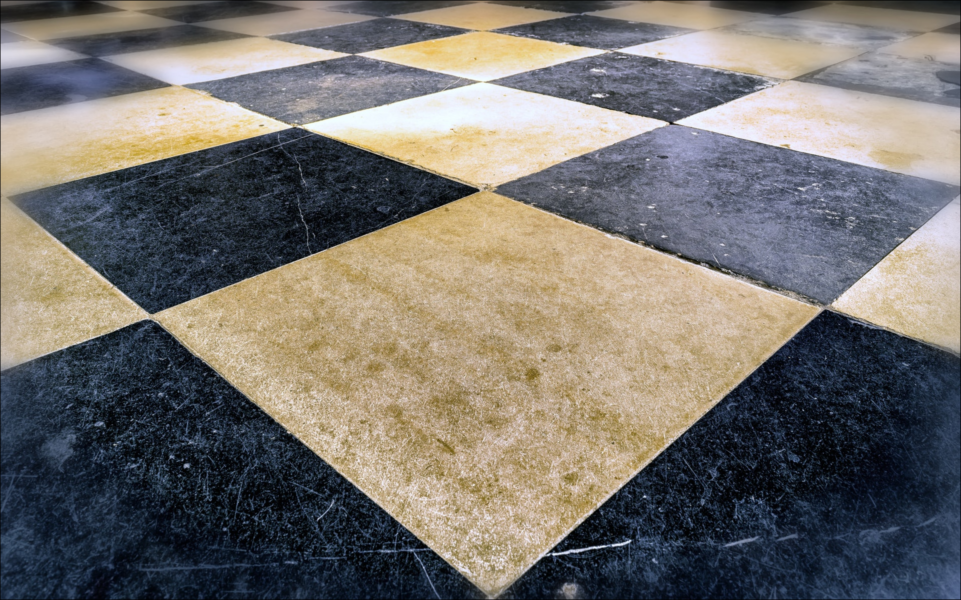

In [35]:
image = load(image_path)

# Converting to Grayscale
For our purposes, having a color image is not very useful. All we need is the luminance of each pixel. To get this, we simply convert the image to grayscale.

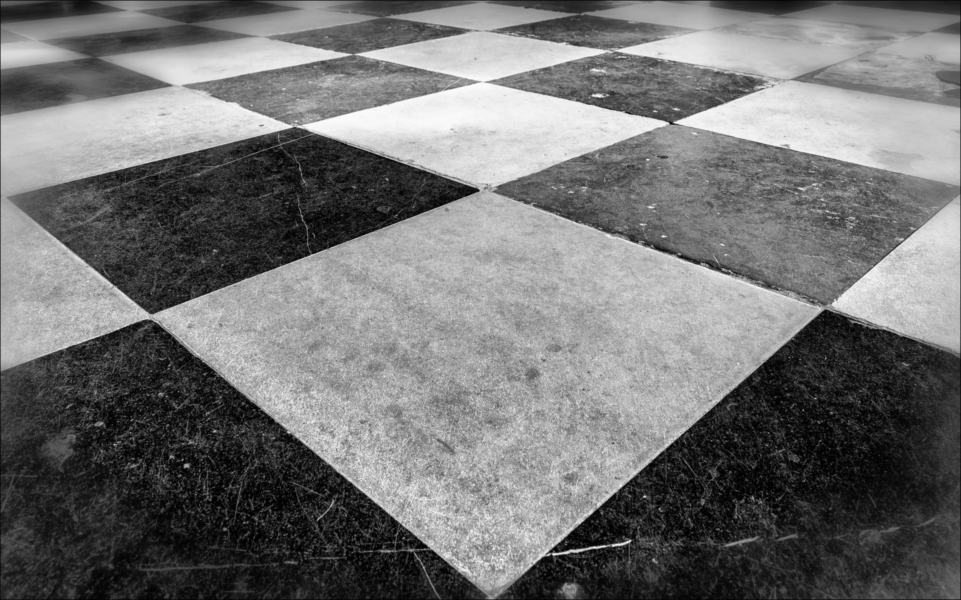

In [36]:
gray_image = Gray.(image)

# Blurring the Image
There is still a lot of noise and irrelevant information in this photo, such as the scratches and marks on the floor. This will make it somewhat more difficult to cleanly identify the borders of the mosaic tiles, which are really the only lines that we care about. To help with this, we actually remove detail from the photo by blurring it with a [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur).

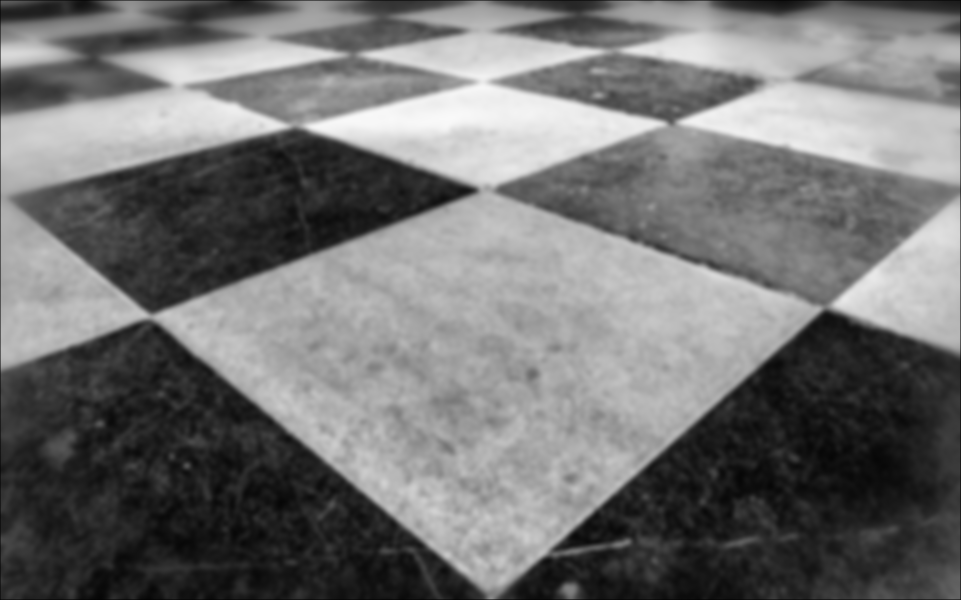

In [37]:
blur_image = imfilter(gray_image, Kernel.gaussian(5))

# Identifying the Edges
A straight line in the image is a special case of an edge in the image, so a reasonable next step is to identify all of the edges, including the non-straight ones. We use the [Canny edge detector](https://en.wikipedia.org/wiki/Canny_edge_detector) to accomplish this.

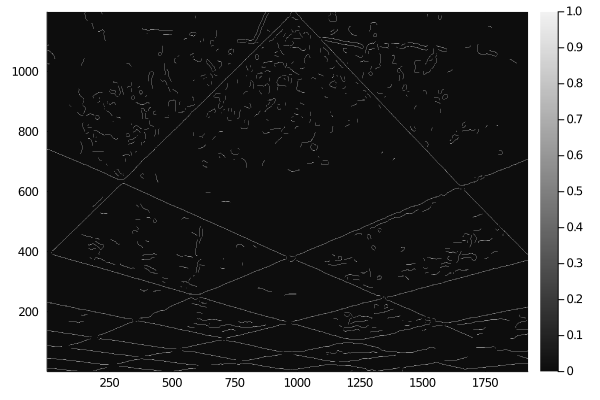

In [38]:
edge_image = canny(blur_image, (Images.Percentile(99), Images.Percentile(75)))
heatmap(edge_image, color = :grays)

# Identifying the Straight Edges
In order to figure out which of those edges are straight lines, we first need to ponder what it means to be a straight line. One way to express a line is $y = mx + b$, as we learned in elementary school. However, this form has some disadvantages, such as how it cannot represent vertical lines. Instead, we will use the [normal form][1] of a line, $x \cos(\theta) + y \sin(\theta) = \rho$, which expresses a line primarily in terms of its distance $\rho$ from the origin. If we were to draw the shortest distance from the origin to the line, this "distance vector" would be [perpendicular to the line itself][2]. However, we need more than just the distance from the origin, because there are an infinite number of possible lines with that particular distance from the origin. The solution is to also record the angle $\theta$ that this particular "distance vector" makes with the origin. Therefore, we can uniquely express a line by starting at the origin, pointing in the direction $\theta$, and then moving a distance of $\rho$ away from the origin in this direction. Then, the line is the unique line that is perpendicular to the "distance vector" at that point.

[1]: https://en.wikipedia.org/wiki/Line_(geometry)#Normal_form
[2]: https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line

Now that we know how to express a line, how do we know which of the image's edge points belong to a line? In the expression $x \cos(\theta) + y \sin(\theta) = \rho$, we consider $\theta$ and $\rho$ to be given, since they uniquely encode the line. $x$ and $y$ are variable, and any value of $(x,y)$ that satisfies the equation is a point that lies on the line. However, we can also flip things around: consider $x$ and $y$ to be given and fixed, and consider $\theta$ and $\rho$ to be variable. Now, any value of $(\theta, \rho)$ that satisfies the equation represents a line that passes through the point $(x, y)$. In this way, we can conveniently keep track of *all* possible lines that pass through a particular edge point in the image. If we do this repeatedly for all of the edge points, we'll see some of these possible lines more often than others. In particular, if a sequence of edge points are perfectly collinear, then the unique line that passes through all of these points will be the one and only possible line that we'll see for each and every one of those edge points. This allows us to "vote" for every possible line for each edge point, and the lines that pass through the most edge points will receive the most votes. These lines are most likely to be the actual lines found in our image.

Since we're dealing with a discrete computer, we can't literally consider every possible line, though. Instead, we divide the possible values of $\rho$ and $\theta$ into discrete "buckets".

In [39]:
function vote(edge_image::AbstractArray{Bool, 2},
              magnitudes::AbstractVector{Float64},
              cosines::AbstractVector{Float64},
              sines::AbstractVector{Float64})
    votes = zeros(Int64, size(magnitudes, 1), size(cosines, 1))

    for coordinate in CartesianIndices(edge_image)
        if 0 < edge_image[coordinate]
            y, x = coordinate.I

            for θ in 1:size(cosines, 1)
                ρ = x * cosines[θ] + y * sines[θ]
                closest_ρ = argmin(abs.(magnitudes .- ρ))
                votes[closest_ρ, θ] += 1
            end
        end
    end

    votes
end

vote (generic function with 1 method)

In [40]:
function hough(edge_image::AbstractArray{Bool, 2})
    max_ρ = ceil(sqrt(sum(size(edge_image) .^ 2)))
    magnitudes = range(-max_ρ, max_ρ; step = 1)
    angles = range(0, π; step = π / 180)
    cosines = Vector{Float64}(undef, length(angles))
    sines = Vector{Float64}(undef, length(angles))

    for (index, θ) in enumerate(angles)
        cosines[index] = cos(θ)
        sines[index] = sin(θ)
    end

    (
        vote(edge_image, magnitudes, cosines, sines),
        magnitudes,
        angles,
        cosines,
        sines,
    )
end

hough (generic function with 1 method)

In [41]:
vote_space, magnitudes, angles, cosines, sines = hough(edge_image)

([0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], -2264.0:1.0:2264.0, 0.0:0.017453292519943295:3.141592653589793, [1.0, 0.9998476951563913, 0.9993908270190958, 0.9986295347545738, 0.9975640502598242, 0.9961946980917455, 0.9945218953682733, 0.992546151641322, 0.9902680687415704, 0.9876883405951378  …  -0.9876883405951377, -0.9902680687415704, -0.992546151641322, -0.9945218953682733, -0.9961946980917455, -0.9975640502598242, -0.9986295347545738, -0.9993908270190958, -0.9998476951563913, -1.0], [0.0, 0.01745240643728351, 0.03489949670250097, 0.052335956242943835, 0.0697564737441253, 0.08715574274765817, 0.10452846326765347, 0.12186934340514748, 0.13917310096006544, 0.15643446504023087  …  0.15643446504023098, 0.13917310096006533, 0.12186934340514755, 0.10452846326765373, 0.0871557427476582, 0.06975647374412552, 0.05233595624294381, 0.03489949670250114, 0.01745240643728344, 1.2246467991473532e-16])

# Visualizing the Votes

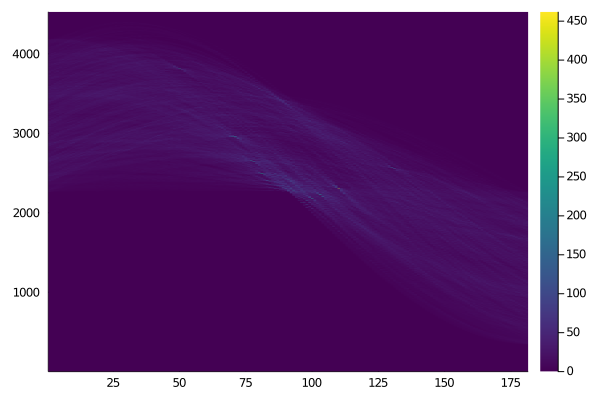

In [42]:
heatmap(vote_space, color = :viridis)

# Finding the Most Popular Lines
The bright "peaks" in the above heatmap represent the most likely lines in the image. Due to noise and imperfections in the image, as well as imperfections with our discrete "binning" process, the peaks are not perfectly contained within individual buckets. A single line might cause there to be multiple adjacent buckets that are extremely highly-voted. Thus, we zero out the buckets surrounding every peak, to avoid identifying the same line multiple times.

In [43]:
function peaks!(vote_space::AbstractArray{Int64, 2}, channel::Channel{CartesianIndex})
    rows, cols = size(vote_space)
    coordinates = CartesianIndices(vote_space)
    threshold = maximum(vote_space) / 2
    max_peaks = 10
    peaks_found = 0
    neighborhood_size = size(vote_space) .÷ 100 .* 2 .+ 1
    neighborhood_center = (neighborhood_size .+ 1) .÷ 2

    while true
        max_bin = argmax(vote_space)
        if threshold <= vote_space[max_bin]
            peaks_found += 1
            bin_y, bin_x = coordinates[max_bin].I

            put!(channel, max_bin)
            for Δx in -neighborhood_center[2]:neighborhood_center[2]
                for Δy in -neighborhood_center[1]:neighborhood_center[1]
                    y = bin_y + Δy
                    x = bin_x + Δx

                    if 1 <= x && x <= cols && 1 <= y && y <= rows
                        vote_space[y, x] = 0
                    end
                end
            end
            
            if peaks_found == max_peaks
                break
            end
        else
            break
        end
    end
end

peaks! (generic function with 1 method)

In [44]:
peaks = [coordinate.I for coordinate in Channel{CartesianIndex}(c -> peaks!(vote_space, c))]

8-element Array{Tuple{Int64,Int64},1}:
 (2310, 110)
 (2954, 71)
 (2401, 84)
 (2225, 103)
 (2495, 81)
 (3815, 50)
 (2654, 77)
 (2178, 100)

# Visualizing the Votes After Removing Peaks

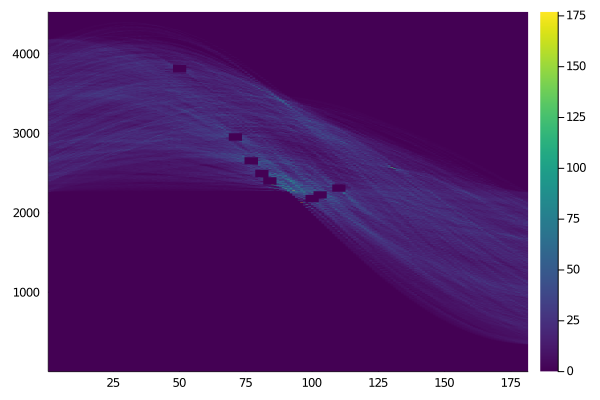

In [45]:
heatmap(vote_space, color = :viridis)

# Overlaying the Lines on the Image
Now that we have the $(\theta, \rho)$ Hough space coordinates of each of the most likely lines in the image, we can simply plot these lines on top of the image by graphing the lines using their normal form, $x \cos(\theta) + y \sin(\theta) = \rho$. We use a convenient function `LineNormal()` to do this.

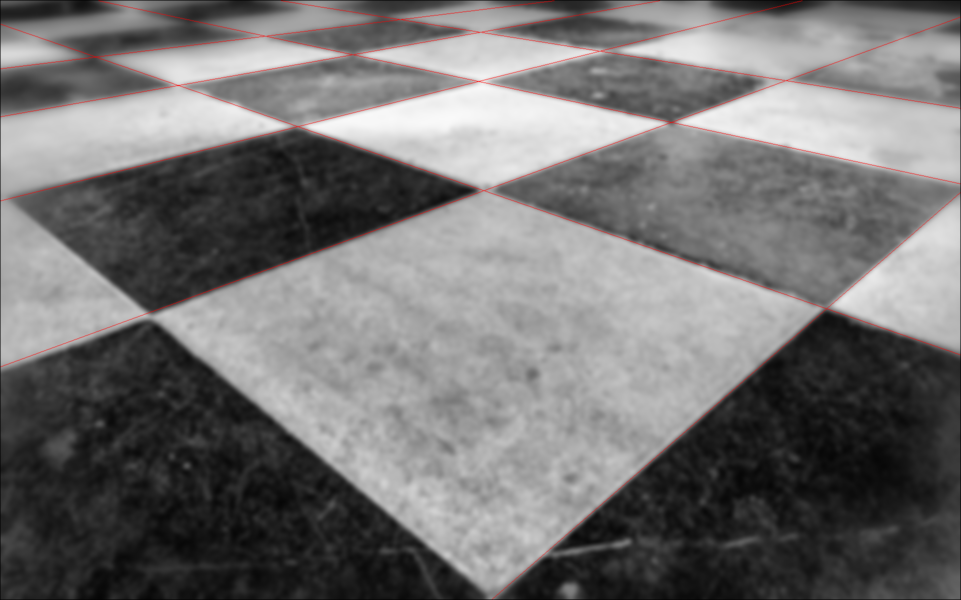

In [46]:
height, width = size(blur_image)

line_image = RGB{N0f8}.(blur_image)

for (ρ, θ) in peaks
    draw!(line_image, LineNormal(magnitudes[ρ], angles[θ]), RGB{N0f8}(1, 0, 0))
end

line_image